In [16]:
import numpy as np
import pandas as pd

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [18]:
train = train.drop(columns = 'id')
X_train = train.drop(columns = 'feature_2') 
Y_train = train.feature_2

In [19]:
X_train['time'] = pd.to_datetime(X_train.time)

In [20]:
X_train

,time,feature_1
0,2019-03-19 00:00:00,735.740043
1,2019-03-19 00:00:10,734.102947
2,2019-03-19 00:00:20,730.060336
3,2019-03-19 00:00:30,725.609742
4,2019-03-19 00:00:40,724.328480
...,...,...
559,2019-03-19 01:33:10,423.726707
560,2019-03-19 01:33:20,424.278568
561,2019-03-19 01:33:30,420.127639
562,2019-03-19 01:33:40,421.291993


In [21]:
X_train = X_train.drop(X_train.index[0], inplace = False)
Y_train = Y_train.drop(Y_train.index[0], inplace = False)

In [22]:
x_train = X_train['time'][:504]
y_train = Y_train[:504]
x_test = X_train['time'][504:]
y_test = Y_train[504:]

In [23]:
ts = pd.concat([x_train, y_train], axis = 1)

In [24]:
ts = ts.set_index('time')

In [25]:
testts = pd.concat([x_train, y_train], axis = 1)
testts = testts.set_index('time')

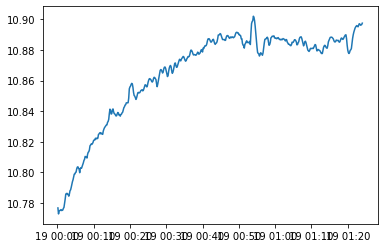

In [26]:
import matplotlib.pyplot as plt
ts_log = np.log(ts)
plt.plot(ts_log)

In [27]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=60).mean()
    rolstd = timeseries.rolling( window=60).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

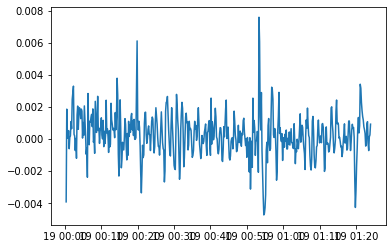

In [28]:
#differnencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

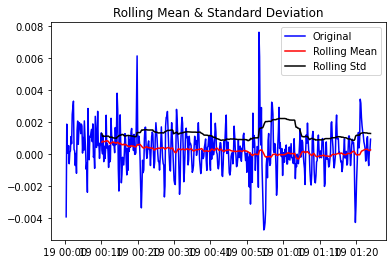

Results of Dickey-Fuller Test:
Test Statistic                -1.222371e+01
p-value                        1.092537e-22
#Lags Used                     1.000000e+00
Number of Observations Used    5.010000e+02
Critical Value (1%)           -3.443470e+00
Critical Value (5%)           -2.867326e+00
Critical Value (10%)          -2.569852e+00
dtype: float64


In [29]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

<ipython-input-30-553c10e3addb>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(ts, freq = 60, model = "multiplicative")


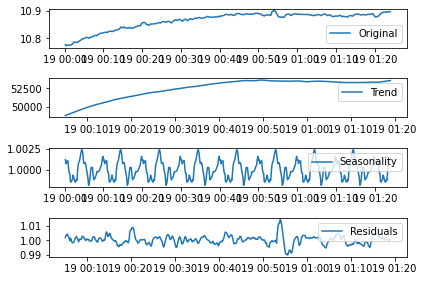

In [30]:
#decomposing.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, freq = 60, model = "multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [36]:
decomposition.resid.dropna(inplace = True)

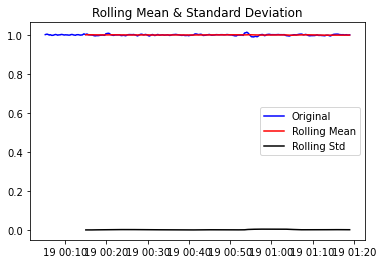

Results of Dickey-Fuller Test:
Test Statistic                -7.317721e+00
p-value                        1.216849e-10
#Lags Used                     8.000000e+00
Number of Observations Used    4.350000e+02
Critical Value (1%)           -3.445473e+00
Critical Value (5%)           -2.868207e+00
Critical Value (10%)          -2.570321e+00
dtype: float64


In [39]:
test_stationarity(decomposition.resid)

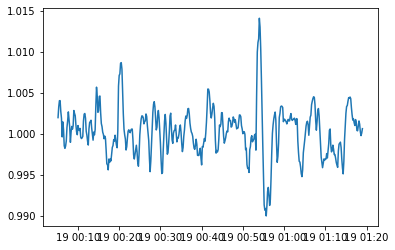

In [41]:
plt.plot(decomposition.resid)

We'll go with the decomposed time-series. Looking at the 

Lets try to forecast this modified time-series.

In [48]:
new_ts = decomposition.resid
print("Shape of the new modified time-series:", new_ts.shape)

Shape of the new modified time-series: (444,)


In [49]:
train = new_ts[:-60]
test = new_ts[-60:]
print("Shape of the train set:", train.shape)
print("Shape of the test set:", test.shape)

Shape of the train set: (384,)
Shape of the test set: (60,)


In [50]:
# We'll use auto-arimato find the best configuration about the time-series
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-3756.184, Time=2.77 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2867.794, Time=0.40 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-3738.851, Time=3.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-3550.884, Time=8.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2869.790, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-3758.185, Time=0.49 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-3828.442, Time=0.85 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-3872.737, Time=18.35 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-3851.058, Time=15.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-3870.169, Time=8.79 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-3537.207, Time=24.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-3780.716, Time=5.71 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-3931.501, Time=15.61 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                1973.245
Date:                            Wed, 12 Aug 2020   AIC                          -3936.489
Time:                                    16:33:17   BIC                          -3916.895
Sample:                                         0   HQIC                         -3928.708
                                            - 384                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5199      0.039     38.836      0.000       1.443       1.597
ar.L2         -0.6338      0.042    -15.227      0.000      -0.715      -0.552
ar.S.L12      -0.9423      0.043    -21.915      0.000      -1.027      -0.858
ar.S.L24      -0.5432      0.033    -16.558      0.000      -0.608      -0.479
sigma2      1.378e-06    6.5e-08     21.190      0.000    1.25e-06    1.51e-06
===================================================================================
Ljung-Box (Q):                       77.45   Jarque-Bera (JB):               261.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks like the SARIMAX model witht the above given configration is the best model,

Lets fit the model according to the given config
> (2,1,1)(2,1,0)[12] 

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(train,  
                order = (2,0,0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              resid   No. Observations:                  384
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                1973.245
Date:                            Wed, 12 Aug 2020   AIC                          -3936.489
Time:                                    16:34:39   BIC                          -3916.895
Sample:                                03-19-2019   HQIC                         -3928.708
                                     - 03-19-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5199      0.039     38.836      0.000       1.443       1.597
ar.L2         -0.6338      0.042    -15.227      0.000      -0.715      -0.552
ar.S.L12      -0.9423      0.043    -21.915      0.000      -1.027      -0.858
ar.S.L24      -0.5432      0.033    -16.558      0.000      -0.608      -0.479
sigma2      1.378e-06    6.5e-08     21.190      0.000    1.25e-06    1.51e-06
===================================================================================
Ljung-Box (Q):                       77.45   Jarque-Bera (JB):               261.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='time'>

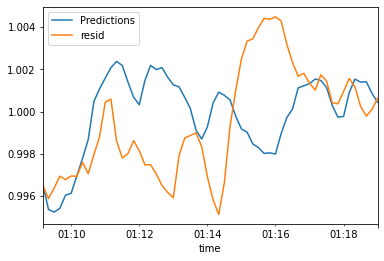

In [53]:
start = len(train) 
end = len(train) + len(test) - 1

# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
							typ = 'levels').rename("Predictions") 

# plot predictions and actual values 
predictions.plot(legend = True) 
test.plot(legend = True) 


In [54]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
rmse(test, predictions) 
  
# Calculate mean squared error 
np.sqrt(mean_squared_error(test, predictions) )

0.0031352586734158493

### FBProphet

In [55]:
training = ts_log_diff.reset_index()
training.columns = ['ds', 'y']

In [56]:
from fbprophet import Prophet
m = Prophet()
m.fit(training)

ModuleNotFoundError: No module named 'fbprophet'

In [50]:
testing = pd.concat([x_test, y_test], axis = 1)
testing = testing.set_index('time')

In [51]:
testing_log = np.log(testing)
testing_log_diff = testing_log - testing_log.shift()
testing_log_diff.dropna(inplace = True)

In [52]:
testing1 = testing_log_diff.reset_index()
testing1.columns = ['ds', 'y']
testing1.head()

,ds,y
0,2019-03-19 01:24:20,-0.000691
1,2019-03-19 01:24:30,-0.001088
2,2019-03-19 01:24:40,-0.000576
3,2019-03-19 01:24:50,-0.000308
4,2019-03-19 01:25:00,-0.000406


In [58]:
b = pd.DataFrame()
b['ds'] = testing1.ds

In [59]:
import sklearn.metrics as metrics 
forecast = m.predict(b)
print(np.sqrt(metrics.mean_squared_error(testing1.y, forecast.yhat)))

0.001007014698787103


In [92]:
actual = pd.read_csv('actual.csv')
testing = pd.read_csv('test.csv')
testing1 = testing.drop(columns = ['id', 'feature_1'])
testing1.columns = ['ds']

In [103]:
forecast1 = m.predict(testing1)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(log_fill1, forecast1.yhat)))

Root Mean Squared Error: 0.0004473699569602179


In [102]:
log_fill1 = lof_diff.fillna(0.000071)
log_fill1

0      0.000071
1      0.000071
2      0.000071
3      0.000071
4      0.000071
         ...   
370    0.000070
371    0.000070
372    0.000070
373    0.000070
374    0.000070
Name: feature_2, Length: 375, dtype: float64